In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import ProgBar
from scipy import stats

pd.set_option("display.max_columns", None)


# Declarando funções utilizadas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import ProgBar
from functools import reduce
from scipy import stats


class snt_reader:
    def __init__(self, file,orgao="RI") -> None:
        bar = ProgBar(6, "Lendo tabelas da planilha...")

        # Lê tabela de incrição
        df_inscricao = pd.read_excel(
            file,
            sheet_name=0,
            header=4,
        )

        df_inscricao = df_inscricao[df_inscricao.Enxerto == orgao]

        bar.update()

        # Lê tabela de obitos
        df_obitos = pd.read_excel(
            file,
            sheet_name=4,
            header=5,
        )

        df_obitos = df_obitos[df_obitos.Enxerto == orgao]

        bar.update()

        # Lê tabela de transplantes
        df_tranplantes = pd.read_excel(
            file,
            sheet_name=2,
            header=4,
        )
        
        df_tranplantes = df_tranplantes[df_tranplantes.Enxerto == orgao]

        bar.update()

        # Fazendo join das tabelas

        dfs = [df_inscricao, df_obitos, df_tranplantes]

        self.final_df = reduce(
            lambda left, right: pd.merge(left, right, on=["ID"], how="outer"), dfs
        )

        bar.update()

        self.treat_nan()

        bar.update()

        self.format_data()

        bar.update()

    def condicional_index(self, tipo):
        if tipo == "transplante":
            return (self.cor_treated_nan_df["data_do_transplante"] != 0) & (
                self.cor_treated_nan_df["data_do_obito"] == 0
            )
        elif tipo == "obito":
            return (self.cor_treated_nan_df["data_do_transplante"] == 0) & (
                self.cor_treated_nan_df["data_do_obito"] != 0
            )

    def treat_nan(self):
        # retirando colunas duplicadas

        filtered_df = self.final_df[
            [
                "ID",
                "Data da Inscrição_x",
                "Data do Óbito",
                "Enxerto_x",
                "UF_x",
                "Região_x",
                "Data do Transplante",
                "Tipo de Doador",
                "UF de Origem",
                "Data de Nascimento_x",
                "Sexo_x",
                "Grupo Sanguíneo_x",
                "Cor_x",
            ]
        ]

        # renomeando colunas

        filtered_df = filtered_df.rename(
            columns={
                "Data da Inscrição_x": "data_da_inscricao",
                "UF_x": "uf",
                "Data do Óbito": "data_do_obito",
                "Enxerto_x": "enxerto",
                "Região_x": "regiao",
                "Data do Transplante": "data_do_transplante",
                "Tipo de Doador": "tipo_do_doador",
                "UF de Origem": "uf_de_origem",
                "Data de Nascimento_x": "data_de_nascimento",
                "Sexo_x": "sexo",
                "Grupo Sanguíneo_x": "grupo_sanguineo",
                "Cor_x": "cor",
            }
        )

        # retirando data de inscrição null

        treated_df = filtered_df.dropna(subset=["data_da_inscricao"])

        # retirando pacientes ainda em fila

        out_patients_df = treated_df.dropna(
            subset=["data_do_obito", "data_do_transplante"], how="all"
        )

        self.n_amostras = len(treated_df)

        # tratanto NaN
        treated_nan_df = out_patients_df
        treated_nan_df.data_do_obito = out_patients_df.data_do_obito.fillna(0)
        treated_nan_df.data_do_transplante = out_patients_df.data_do_transplante.fillna(
            0
        )

        # Retirando dados não confiável de
        # mortalidade pós transplante

        self.cor_treated_nan_df = treated_nan_df.drop(
            index=(
                treated_nan_df.loc[
                    (treated_nan_df["data_do_transplante"] != 0)
                    & (treated_nan_df["data_do_obito"] != 0)
                ].index
            )
        )

    def format_data(self, save_file=True):
        # criando coluna única de tempo,
        # colunas binárias de tipo e tempo de segmento

        tmp_dict = {
            "idade": [],
            "data_do_evento": [],
            "obito_bin": [],
            "transplante_bin": [],
            "delta_t": [],
        }

        # Calculando variáveis para o transplante
        tmp_dict["data_do_evento"] = self.cor_treated_nan_df.loc[
            self.condicional_index("transplante")
        ]["data_do_transplante"].values.tolist()

        tmp_dict["delta_t"] = [
            (transplante - inscricao) / np.timedelta64(1, "D")
            for transplante, inscricao in zip(
                self.cor_treated_nan_df.loc[self.condicional_index("transplante")][
                    "data_do_transplante"
                ].values,
                self.cor_treated_nan_df.loc[self.condicional_index("transplante")][
                    "data_da_inscricao"
                ].values,
            )
        ]

        tmp_dict["idade"] = [
            (transplante - nascimento) / np.timedelta64(1, "D")
            for transplante, nascimento in zip(
                self.cor_treated_nan_df.loc[self.condicional_index("transplante")][
                    "data_do_transplante"
                ].values,
                self.cor_treated_nan_df.loc[self.condicional_index("transplante")][
                    "data_de_nascimento"
                ].values,
            )
        ]

        tmp_dict["obito_bin"] = [
            0
            for _ in range(
                len(self.cor_treated_nan_df.loc[self.condicional_index("transplante")])
            )
        ]
        tmp_dict["transplante_bin"] = [
            1
            for _ in range(
                len(self.cor_treated_nan_df.loc[self.condicional_index("transplante")])
            )
        ]

        # Calculando variáveis para o obito
        tmp_dict["data_do_evento"] += self.cor_treated_nan_df.loc[
            self.condicional_index("obito")
        ]["data_do_obito"].values.tolist()
        tmp_dict["delta_t"] += [
            (obito - inscricao) / np.timedelta64(1, "D")
            for obito, inscricao in zip(
                self.cor_treated_nan_df.loc[self.condicional_index("obito")][
                    "data_do_obito"
                ].values,
                self.cor_treated_nan_df.loc[self.condicional_index("obito")][
                    "data_da_inscricao"
                ].values,
            )
        ]
        tmp_dict["idade"] += [
            (obito - nascimento) / np.timedelta64(1, "D")
            for obito, nascimento in zip(
                self.cor_treated_nan_df.loc[self.condicional_index("obito")][
                    "data_do_obito"
                ].values,
                self.cor_treated_nan_df.loc[self.condicional_index("obito")][
                    "data_de_nascimento"
                ].values,
            )
        ]

        tmp_dict["transplante_bin"] += [
            0
            for _ in range(
                len(self.cor_treated_nan_df.loc[self.condicional_index("obito")])
            )
        ]
        tmp_dict["obito_bin"] += [
            1
            for _ in range(
                len(self.cor_treated_nan_df.loc[self.condicional_index("obito")])
            )
        ]

        concat_df = pd.DataFrame(tmp_dict)

        # unindo colunas calculadas

        formated_df = pd.DataFrame(
            np.hstack((self.cor_treated_nan_df.values, concat_df.values))
        )
        formated_df.columns = (
            self.cor_treated_nan_df.columns.tolist() + concat_df.columns.tolist()
        )

        # retirando colunas despadronizadas

        self.formated_df = formated_df.drop(
            columns=["data_do_obito", "data_do_transplante", "data_de_nascimento"]
        )

        if save_file:
            # salvando base de dados
            formated_df.to_csv(
                "base_de_dados_formatada.csv",
                index=False,
            )

    def kaplan_meier(
        self, verbose=True, plt_show=True, plt_save=True, width=16, height=9, scale=1
    ):
        fig = plt.figure(figsize=[scale * width, scale * height])
        ax = fig.add_subplot(1, 1, 1)
        fig.suptitle("Kaplan-meier", fontsize=16)

        # Plotando curva de óbito
        print("obito: ")
        seg_delta_t_negativo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t < 0) & (self.formated_df.obito_bin == 1)
        ]
        seg_delta_t_positivo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t >= 0) & (self.formated_df.obito_bin == 1)
        ]

        unique_delta, count = np.unique(seg_delta_t_positivo, return_counts=True)

        percentage = []
        acumulada = 100

        for n_vezes in count:
            acumulada -= (n_vezes / self.n_amostras) * 100
            percentage.append(acumulada)

        # Plotando 2D

        ax.plot(unique_delta / 30, percentage, linewidth=2, label="Óbito em fila")

        print("amostras negativas: ", len(seg_delta_t_negativo))
        print("amostras positivas: ", len(seg_delta_t_positivo))

        # Plotando a curva do transplante
        print("transplante: ")
        seg_delta_t_negativo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t < 0) & (self.formated_df.transplante_bin == 1)
        ]
        seg_delta_t_positivo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t >= 0) & (self.formated_df.transplante_bin == 1)
        ]

        unique_delta, count = np.unique(seg_delta_t_positivo, return_counts=True)

        percentage = []
        acumulada = 100

        for n_vezes in count:
            acumulada -= (n_vezes / self.n_amostras) * 100
            percentage.append(acumulada)

        # Plotando 2D

        ax.plot(unique_delta / 30, percentage, linewidth=2, label="Transplante")

        print("amostras negativas: ", len(seg_delta_t_negativo))
        print("amostras positivas: ", len(seg_delta_t_positivo))

        # Plotando curva da fila
        print("fila: ")
        seg_delta_t_negativo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t < 0)
        ]
        seg_delta_t_positivo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t >= 0)
        ]

        unique_delta, count = np.unique(seg_delta_t_positivo, return_counts=True)

        percentage = []
        acumulada = 100

        for n_vezes in count:
            acumulada -= (n_vezes / self.n_amostras) * 100
            percentage.append(acumulada)

        # Plotando 2D

        ax.plot(unique_delta / 30, percentage, linewidth=2, label="Fila")

        print("amostras negativas: ", len(seg_delta_t_negativo))
        print("amostras positivas: ", len(seg_delta_t_positivo))

        ax.set_ylabel("Probabilidade", fontsize=16)
        ax.set_xlabel("Meses", fontsize=16)

        ax.legend()
        ax.grid()

        if plt_show:
            plt.show()

        if plt_show:
            plt.savefig("figures/kpm.png")

    def pdf(
        self, verbose=True, plt_show=True, plt_save=True, width=16, height=9, scale=1
    ):
        fig = plt.figure(figsize=[scale * width, scale * height])
        ax = fig.add_subplot(1, 1, 1)
        fig.suptitle("FDP", fontsize=16)

        print("obito: ")
        seg_delta_t_negativo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t < 0) & (self.formated_df.obito_bin == 1)
        ]
        seg_delta_t_positivo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t >= 0) & (self.formated_df.obito_bin == 1)
        ].values

        gs_kernel = stats.gaussian_kde(seg_delta_t_positivo.astype(np.float64))

        # defining attributes limits

        smp_max = max(seg_delta_t_positivo)

        smp_min = min(seg_delta_t_positivo)

        # creating values interval for time optimization

        smp_eval = np.linspace(smp_min, smp_max, num=500)

        # calculating the likelyhood with kde kernel

        smp_likelyhood = gs_kernel(smp_eval)

        ax.plot(smp_eval, smp_likelyhood, linewidth=2, label="Óbito")

        print("amostras negativas: ", len(seg_delta_t_negativo))
        print("amostras positivas: ", len(seg_delta_t_positivo))

        # Plotando a curva do transplante
        print("transplante: ")
        seg_delta_t_negativo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t < 0) & (self.formated_df.transplante_bin == 1)
        ]
        seg_delta_t_positivo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t >= 0) & (self.formated_df.transplante_bin == 1)
        ].values

        gs_kernel = stats.gaussian_kde(seg_delta_t_positivo.astype(np.float64))

        # defining attributes limits

        smp_max = max(seg_delta_t_positivo)

        smp_min = min(seg_delta_t_positivo)

        # creating values interval for time optimization

        smp_eval = np.linspace(smp_min, smp_max, num=500)

        # calculating the likelyhood with kde kernel

        smp_likelyhood = gs_kernel(smp_eval)

        ax.plot(smp_eval, smp_likelyhood, linewidth=2, label="Transplante")

        # Plotando curva de fila
        print("fila: ")
        seg_delta_t_negativo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t < 0)
        ]
        seg_delta_t_positivo = self.formated_df.delta_t.loc[
            (self.formated_df.delta_t >= 0)
        ].values

        gs_kernel = stats.gaussian_kde(seg_delta_t_positivo.astype(np.float64))

        # defining attributes limits

        smp_max = max(seg_delta_t_positivo)

        smp_min = min(seg_delta_t_positivo)

        # creating values interval for time optimization

        smp_eval = np.linspace(smp_min, smp_max, num=500)

        # calculating the likelyhood with kde kernel

        smp_likelyhood = gs_kernel(smp_eval)

        ax.plot(smp_eval, smp_likelyhood, linewidth=2, label="Fila")

        print("amostras negativas: ", len(seg_delta_t_negativo))
        print("amostras positivas: ", len(seg_delta_t_positivo))

        print("amostras negativas: ", len(seg_delta_t_negativo))
        print("amostras positivas: ", len(seg_delta_t_positivo))

        ax.set_ylabel("Probabilidade", fontsize=16)
        ax.set_xlabel("Meses", fontsize=16)

        ax.grid()
        ax.legend()

        if plt_show:
            plt.show()

        if plt_show:
            plt.savefig("figures/kpm.png")

# Iniciando objeto

In [4]:
arquivo = "bases_de_dados/Base de Dados_Doação e Transplantes_2015-2023.xlsx"

reader = snt_reader(arquivo)

Lendo tabelas da planilha...
[-----------------------------------------        ] 83.33% - 5 of 66

/tmp/ipykernel_16534/4261311765.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_nan_df.data_do_obito = out_patients_df.data_do_obito.fillna(0)
/tmp/ipykernel_16534/4261311765.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_nan_df.data_do_transplante = out_patients_df.data_do_transplante.fillna(


[--------------------------------------------------] 100.00% - 6 of 6

# Tempo até óbito em fila

obito: 
amostras negativas:  10
amostras positivas:  9257
transplante: 
amostras negativas:  231
amostras positivas:  38100
fila: 
amostras negativas:  241
amostras positivas:  47357


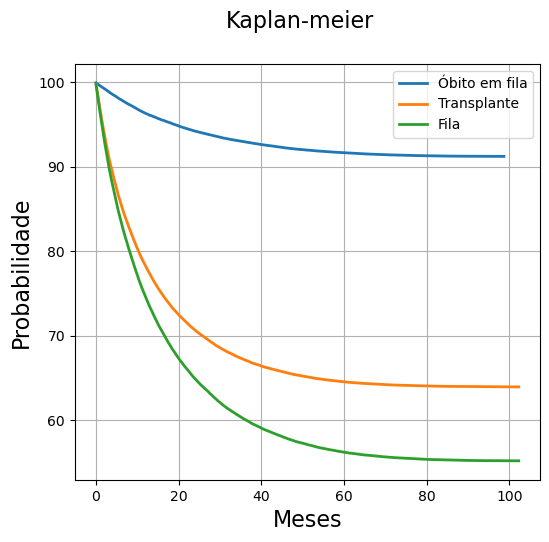

<Figure size 640x480 with 0 Axes>

In [6]:
reader.kaplan_meier(width=10,scale=0.6)

# PDF

obito: 
amostras negativas:  10
amostras positivas:  9257
transplante: 
fila: 
amostras negativas:  241
amostras positivas:  47357
amostras negativas:  241
amostras positivas:  47357


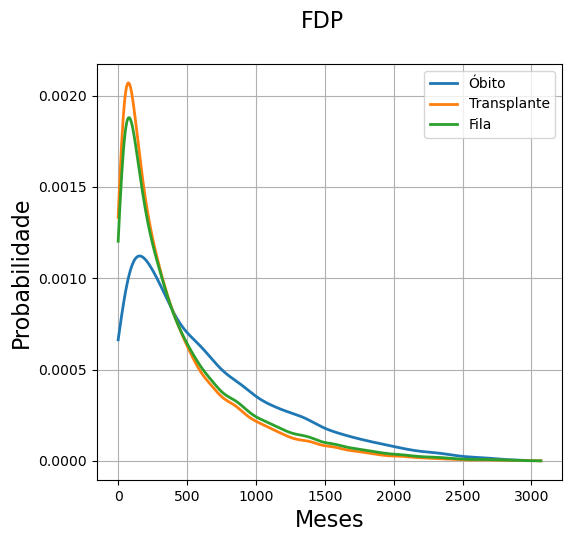

<Figure size 640x480 with 0 Axes>

In [7]:
reader.pdf(width=10,scale=0.6)

# Estudo inicial

## Tempo até o óbito em fila

In [8]:
arquivo = "bases_de_dados/Base de Dados_Doação e Transplantes_2015-2023.xlsx"

In [12]:
# Reading spread-sheet

header_row = 4

df_inscricao = pd.read_excel(
    arquivo,
    sheet_name=0,
    header=header_row,
)

df_inscricao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105620 entries, 2 to 325666
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   UF                      105620 non-null  object        
 1   Região                  105620 non-null  object        
 2   ID                      105620 non-null  object        
 3   Ano                     105620 non-null  int64         
 4   Mês                     105620 non-null  object        
 5   Data da Inscrição       105620 non-null  datetime64[ns]
 6   Enxerto                 105620 non-null  object        
 7   Data de Nascimento      105620 non-null  datetime64[ns]
 8   Sexo                    105620 non-null  object        
 9   Grupo Sanguíneo         105620 non-null  object        
 10  Cor                     105620 non-null  object        
 11  UF origem               105620 non-null  object        
 12  Equipe                  105620 non-

In [13]:
df_inscricao = df_inscricao[df_inscricao.Enxerto == "RI"]
df_inscricao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105620 entries, 2 to 325666
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   UF                      105620 non-null  object        
 1   Região                  105620 non-null  object        
 2   ID                      105620 non-null  object        
 3   Ano                     105620 non-null  int64         
 4   Mês                     105620 non-null  object        
 5   Data da Inscrição       105620 non-null  datetime64[ns]
 6   Enxerto                 105620 non-null  object        
 7   Data de Nascimento      105620 non-null  datetime64[ns]
 8   Sexo                    105620 non-null  object        
 9   Grupo Sanguíneo         105620 non-null  object        
 10  Cor                     105620 non-null  object        
 11  UF origem               105620 non-null  object        
 12  Equipe                  105620 non-

In [14]:
# Reading spread-sheet

header_row = 5

df_obitos = pd.read_excel(
    arquivo,
    sheet_name=4,
    header=header_row,
)
df_obitos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20225 entries, 0 to 20224
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   UF                      20225 non-null  object        
 1   Região                  20225 non-null  object        
 2   ID                      20225 non-null  object        
 3   Data de Nascimento      20225 non-null  int64         
 4   Sexo                    20225 non-null  object        
 5   Grupo Sanguíneo         19747 non-null  object        
 6   Cor                     20225 non-null  object        
 7   Ano                     20225 non-null  int64         
 8   Mês                     20225 non-null  object        
 9   Data do Óbito           20225 non-null  datetime64[ns]
 10  Enxerto                 20225 non-null  object        
 11  Equipe                  20225 non-null  object        
 12   Estabelecimento        20225 non-null  object

In [15]:
df_obitos = df_obitos[df_obitos.Enxerto == "RI"]
df_obitos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12421 entries, 0 to 20223
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   UF                      12421 non-null  object        
 1   Região                  12421 non-null  object        
 2   ID                      12421 non-null  object        
 3   Data de Nascimento      12421 non-null  int64         
 4   Sexo                    12421 non-null  object        
 5   Grupo Sanguíneo         12421 non-null  object        
 6   Cor                     12421 non-null  object        
 7   Ano                     12421 non-null  int64         
 8   Mês                     12421 non-null  object        
 9   Data do Óbito           12421 non-null  datetime64[ns]
 10  Enxerto                 12421 non-null  object        
 11  Equipe                  12421 non-null  object        
 12   Estabelecimento        12421 non-null  object     

In [16]:
df_result = df_inscricao.set_index("ID").join(
    df_obitos.set_index("ID"), on=["ID"], lsuffix="_insc", rsuffix="_obt"
)
df_result.head()

,UF_insc,Região_insc,Ano_insc,Mês_insc,Data da Inscrição,Enxerto_insc,Data de Nascimento_insc,Sexo_insc,Grupo Sanguíneo_insc,Cor_insc,...,Grupo Sanguíneo_obt,Cor_obt,Ano_obt,Mês_obt,Data do Óbito,Enxerto_obt,Equipe_obt,Estabelecimento_obt,Cidade Estabelecimento_obt,Evento
ID,,,,,,,,,,,,,,,,,,,,,
124877PB,PB,Nordeste,2015,Janeiro,2015-01-02,RI,1974-09-25,M,O,Parda,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
124880PB,PB,Nordeste,2015,Janeiro,2015-01-02,RI,1965-11-27,M,A,Parda,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
124872PB,PB,Nordeste,2015,Janeiro,2015-01-02,RI,1962-12-16,M,O,Parda,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
124873PB,PB,Nordeste,2015,Janeiro,2015-01-02,RI,1948-01-10,M,O,Parda,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
124876PB,PB,Nordeste,2015,Janeiro,2015-01-02,RI,1984-03-02,F,A,Parda,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [17]:
df_result_pre_pro = df_result.dropna(subset=["Data do Óbito"])

In [18]:
delta_t = (
    (
        df_result_pre_pro["Data do Óbito"].values
        - df_result_pre_pro["Data da Inscrição"].values
    )
    / np.timedelta64(1, "D")
    / 30
)

In [19]:
delta_t_negativo = delta_t[delta_t < 0]
delta_t_positivo = delta_t[delta_t >= 0]

print("amostras negativas: ", len(delta_t_negativo))
print("amostras positivas: ", len(delta_t_positivo))

amostras negativas:  10
amostras positivas:  9258


In [20]:
unique_delta, count = np.unique(delta_t_positivo, return_counts=True)

percentage = []
acumulada = 100

for delta, n_vezes in zip(unique_delta, count):
    acumulada -= (n_vezes / n_amostras) * 100
    percentage.append(acumulada)

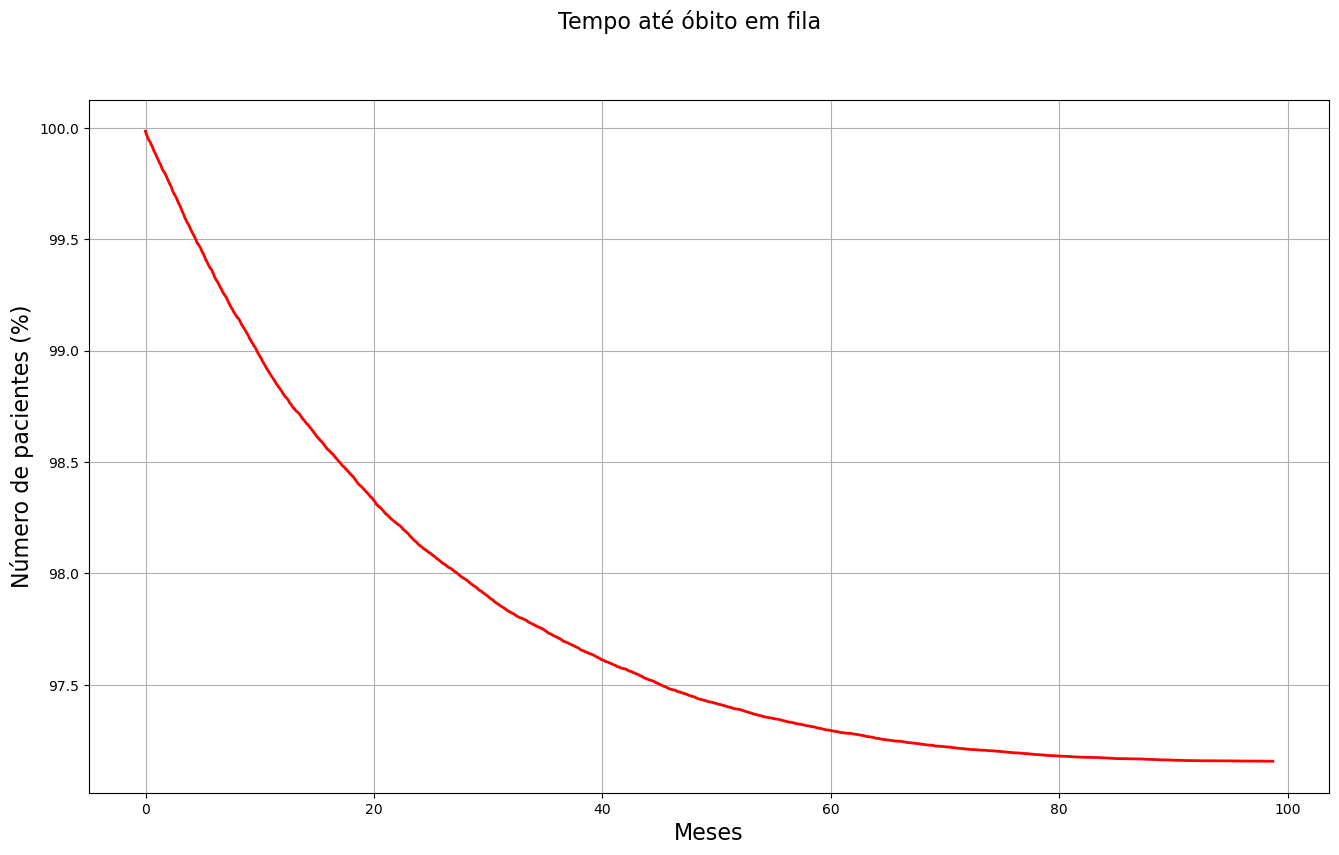

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[16, 9])
fig.suptitle("Tempo até óbito em fila", fontsize=16)

# Plotando 2D

ax = fig.add_subplot(1, 1, 1)

ax.set_ylabel("Número de pacientes (%)", fontsize=16)
ax.set_xlabel("Meses", fontsize=16)

ax.plot(unique_delta, percentage, "r", linewidth=2)

ax.grid()

plt.show()

## Tempo até tranplante

In [22]:
header_row = 4

df_tranplantes = pd.read_excel(
    arquivo,
    sheet_name=2,
    header=header_row,
)

df_tranplantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185771 entries, 0 to 185770
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0    Ano do Transplante     185771 non-null  int64         
 1    Mês do Transplante     185771 non-null  object        
 2   Enxerto                 185771 non-null  object        
 3   UF                      185771 non-null  object        
 4   Região                  185771 non-null  object        
 5   Data da Inscrição       185771 non-null  datetime64[ns]
 6   Data do Transplante     185771 non-null  datetime64[ns]
 7   Tipo de Doador          185771 non-null  object        
 8   UF de Origem            185771 non-null  object        
 9   ID                      185771 non-null  object        
 10  Data de Nascimento      185771 non-null  datetime64[ns]
 11  Sexo                    185771 non-null  object        
 12  Grupo Sanguíneo         69412 

In [23]:
df_tranplantes = df_tranplantes[df_tranplantes.Enxerto == "RI"]
df_tranplantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46465 entries, 2 to 185770
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0    Ano do Transplante     46465 non-null  int64         
 1    Mês do Transplante     46465 non-null  object        
 2   Enxerto                 46465 non-null  object        
 3   UF                      46465 non-null  object        
 4   Região                  46465 non-null  object        
 5   Data da Inscrição       46465 non-null  datetime64[ns]
 6   Data do Transplante     46465 non-null  datetime64[ns]
 7   Tipo de Doador          46465 non-null  object        
 8   UF de Origem            46465 non-null  object        
 9   ID                      46465 non-null  object        
 10  Data de Nascimento      46465 non-null  datetime64[ns]
 11  Sexo                    46465 non-null  object        
 12  Grupo Sanguíneo         46465 non-null  object    

In [24]:
df_result = df_inscricao.set_index("ID").join(
    df_tranplantes.set_index("ID"), on=["ID"], lsuffix="_insc", rsuffix="_obt"
)
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105620 entries, 124877PB to 313294SP
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   UF_insc                      105620 non-null  object        
 1   Região_insc                  105620 non-null  object        
 2   Ano                          105620 non-null  int64         
 3   Mês                          105620 non-null  object        
 4   Data da Inscrição_insc       105620 non-null  datetime64[ns]
 5   Enxerto_insc                 105620 non-null  object        
 6   Data de Nascimento_insc      105620 non-null  datetime64[ns]
 7   Sexo_insc                    105620 non-null  object        
 8   Grupo Sanguíneo_insc         105620 non-null  object        
 9   Cor_insc                     105620 non-null  object        
 10  UF origem                    105620 non-null  object        
 11  Equipe_insc           

In [31]:
df_result_pre_pro = df_result.dropna(subset=["Data do Transplante"])
df_result_pre_pro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38332 entries, 124877PB to 328798MG
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   UF_insc                      38332 non-null  object        
 1   Região_insc                  38332 non-null  object        
 2   Ano                          38332 non-null  int64         
 3   Mês                          38332 non-null  object        
 4   Data da Inscrição_insc       38332 non-null  datetime64[ns]
 5   Enxerto_insc                 38332 non-null  object        
 6   Data de Nascimento_insc      38332 non-null  datetime64[ns]
 7   Sexo_insc                    38332 non-null  object        
 8   Grupo Sanguíneo_insc         38332 non-null  object        
 9   Cor_insc                     38332 non-null  object        
 10  UF origem                    38332 non-null  object        
 11  Equipe_insc                  38332 n

In [32]:
delta_t = (
    (
        df_result_pre_pro["Data do Transplante"].values
        - df_result_pre_pro["Data da Inscrição_insc"].values
    )
    / np.timedelta64(1, "D")
    / 30
)

In [33]:
delta_t_negativo = delta_t[delta_t < 0]
delta_t_positivo = delta_t[delta_t >= 0]

print("amostras negativas: ", len(delta_t_negativo))
print("amostras positivas: ", len(delta_t_positivo))

amostras negativas:  231
amostras positivas:  38101


In [35]:
unique_delta, count = np.unique(delta_t_positivo, return_counts=True)

percentage = []
acumulada = 100

for delta, n_vezes in zip(unique_delta, count):
    acumulada -= (n_vezes / n_amostras) * 100
    percentage.append(acumulada)

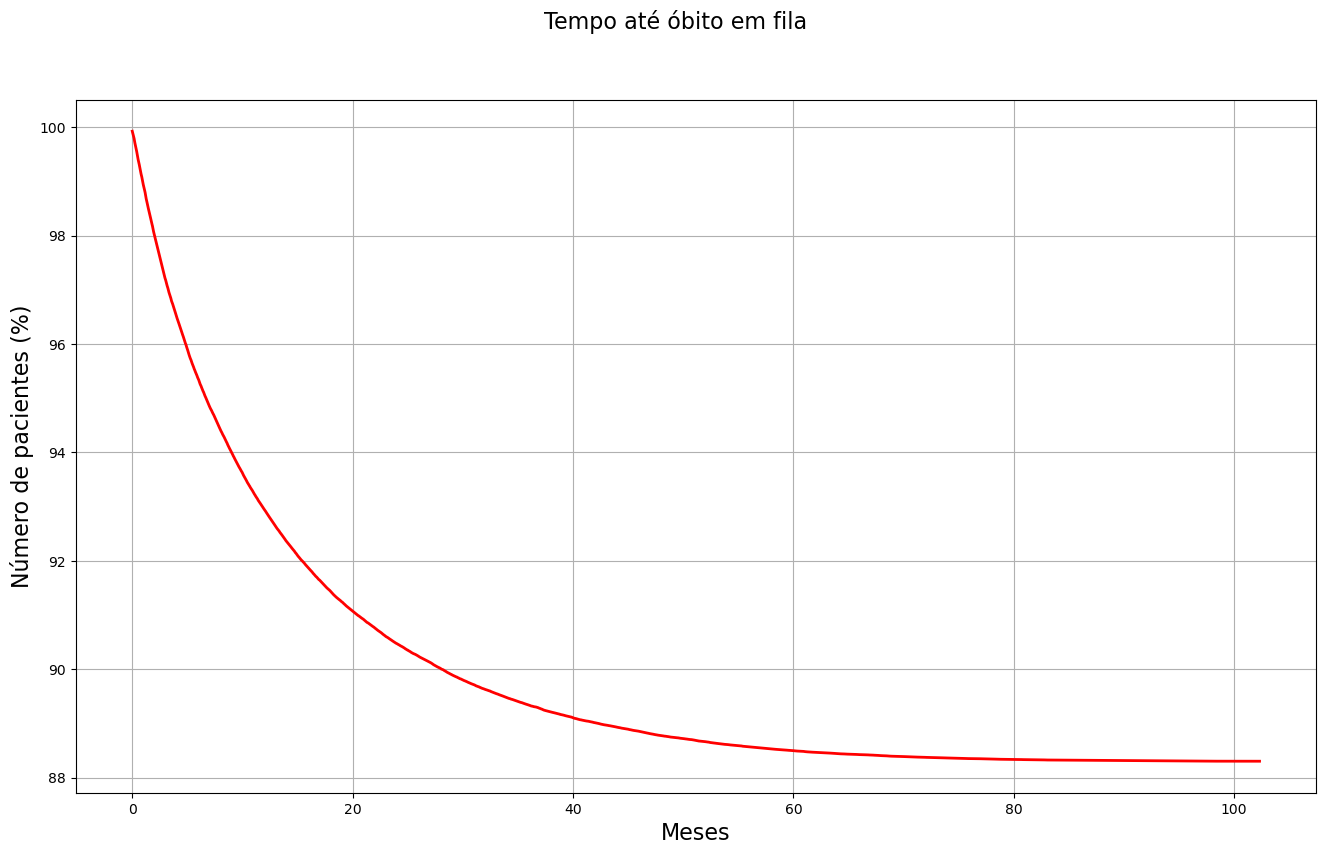

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[16, 9])
fig.suptitle("Tempo até óbito em fila", fontsize=16)

# Plotando 2D

ax = fig.add_subplot(1, 1, 1)

ax.set_ylabel("Número de pacientes (%)", fontsize=16)
ax.set_xlabel("Meses", fontsize=16)

ax.plot(unique_delta, percentage, "r", linewidth=2)

ax.grid()

plt.show()

## Tempo em fila

In [14]:
# Reading spread-sheet

header_row = 4

df_tranplantes = pd.read_excel(
    arquivo,
    sheet_name=2,
    header=header_row,
)

df_tranplantes.head()

,Ano do Transplante,Mês do Transplante,Enxerto,UF,Região,Data da Inscrição,Data do Transplante,Tipo de Doador,UF de Origem,ID,Data de Nascimento,Sexo,Grupo Sanguíneo,Cor,Equipe,Estabelecimento,Cidade Estabelecimento
0,2015,Janeiro,FI,CE,Nordeste,2014-12-04,2015-01-01,Doador Falecido,CE,123647CE,1983-02-06,F,A,Parda,CE - HUWC - José Huygens Parente Garcia,HOSPITAL UNIVERSITARIO WALTER CANTIDIO - HUWC,FORTALEZA
1,2015,Janeiro,FI,PE,Nordeste,2014-12-30,2015-01-01,Doador Falecido,PE,124865PE,1954-01-14,M,O,Parda,PE - HUOC - Cláudio Moura Lacerda,HOSPITAL UNIVERSITÁRIO OSWALDO CRUZ,RECIFE
2,2015,Janeiro,RI,PE,Nordeste,2014-09-26,2015-01-01,Doador Falecido,PE,118654PE,1999-05-18,F,A,Parda,PE - IMIP - Luis Gonzaga de Negreiros Filho,IMIP,RECIFE
3,2015,Janeiro,RI,RS,Sul,2013-05-02,2015-01-01,Doador Falecido,RS,85775RS,1949-03-01,F,B,Branca,RS - ISCMPA - Valter Duro Garcia,IRMANDADE SANTA CASA DE MISERICÓRDIA DE PORTO ...,PORTO ALEGRE
4,2015,Janeiro,RI,RS,Sul,2013-11-22,2015-01-01,Doador Falecido,RS,99196RS,1950-09-29,M,B,Branca,RS - AHCI - Maria Leocádia Amaral Padilha,ASSOCIAÇÃO HOSPITAL DE CARIDADE DE IJUÍ,IJUI


In [15]:
dfs = [df_inscricao, df_obitos, df_tranplantes]

In [16]:
from functools import reduce

final_df = reduce(
    lambda left, right: pd.merge(left, right, on=["ID"], how="outer"), dfs
)

In [17]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344410 entries, 0 to 344409
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   UF_x                      325667 non-null  object        
 1   Região_x                  325667 non-null  object        
 2   ID                        344410 non-null  object        
 3   Ano_x                     325667 non-null  float64       
 4   Mês_x                     325667 non-null  object        
 5   Data da Inscrição_x       325667 non-null  datetime64[ns]
 6   Enxerto_x                 325667 non-null  object        
 7   Data de Nascimento_x      325667 non-null  datetime64[ns]
 8   Sexo_x                    325667 non-null  object        
 9   Grupo Sanguíneo_x         145159 non-null  object        
 10  Cor_x                     325667 non-null  object        
 11  UF origem                 325667 non-null  object        
 12  Eq

In [18]:
final_df.head()

,UF_x,Região_x,ID,Ano_x,Mês_x,Data da Inscrição_x,Enxerto_x,Data de Nascimento_x,Sexo_x,Grupo Sanguíneo_x,Cor_x,UF origem,Equipe_x,Estabelecimento_x,Cidade Estabelecimento_x,UF_y,Região_y,Data de Nascimento_y,Sexo_y,Grupo Sanguíneo_y,Cor_y,Ano_y,Mês_y,Data do Óbito,Enxerto_y,Equipe_y,Estabelecimento_y,Cidade Estabelecimento_y,Evento,Ano do Transplante,Mês do Transplante,Enxerto,UF,Região,Data da Inscrição_y,Data do Transplante,Tipo de Doador,UF de Origem,Data de Nascimento,Sexo,Grupo Sanguíneo,Cor,Equipe,Estabelecimento,Cidade Estabelecimento
0,SP,Sudeste,188975SP,2015.0,Janeiro,2015-01-01,CO,1967-09-06,M,O,Negra,SP,Sírio Libanês - Silvia Moreira Ayub Ferreira,Hospital Sírio Libanês,São Paulo,SP,Sudeste,24721.0,M,O,Negra,2015.0,Março,2015-03-13,CO,Sírio Libanês - Silvia Moreira Ayub Ferreira,Hospital Sírio Libanês,São Paulo,Óbito Pré Transplantes,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,PE,Nordeste,124895PE,2015.0,Janeiro,2015-01-02,FI,1954-04-16,M,O,Parda,PE,PE - IMIP - Cláudio Moura Lacerda de Lima,IMIP,RECIFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,PB,Nordeste,124877PB,2015.0,Janeiro,2015-01-02,RI,1974-09-25,M,O,Parda,PB,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2017.0,Janeiro,RI,PB,Nordeste,2015-01-02,2017-01-29,Doador Falecido,PB,1974-09-25,M,O,Parda,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE
3,PB,Nordeste,124880PB,2015.0,Janeiro,2015-01-02,RI,1965-11-27,M,A,Parda,PB,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2016.0,Dezembro,RI,PB,Nordeste,2015-01-02,2016-12-09,Doador Falecido,PB,1965-11-27,M,A,Parda,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE
4,PB,Nordeste,124872PB,2015.0,Janeiro,2015-01-02,RI,1962-12-16,M,O,Parda,PB,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
final_df.columns

Index(['UF_x', 'Região_x', 'ID', 'Ano_x', 'Mês_x', 'Data da Inscrição_x',
       'Enxerto_x', 'Data de Nascimento_x', 'Sexo_x', 'Grupo Sanguíneo_x',
       'Cor_x', 'UF origem', 'Equipe_x', ' Estabelecimento_x',
       'Cidade Estabelecimento_x', 'UF_y', 'Região_y', 'Data de Nascimento_y',
       'Sexo_y', 'Grupo Sanguíneo_y', 'Cor_y', 'Ano_y', 'Mês_y',
       'Data do Óbito', 'Enxerto_y', 'Equipe_y', ' Estabelecimento_y',
       'Cidade Estabelecimento_y', 'Evento', ' Ano do Transplante',
       ' Mês do Transplante', 'Enxerto', 'UF', 'Região', 'Data da Inscrição_y',
       'Data do Transplante', 'Tipo de Doador', 'UF de Origem',
       'Data de Nascimento', 'Sexo', 'Grupo Sanguíneo', 'Cor', 'Equipe',
       'Estabelecimento', 'Cidade Estabelecimento'],
      dtype='object')

In [22]:
# retirando colunas duplicadas

filtered_df = final_df[
    [
        "ID",
        "Data da Inscrição_x",
        "Data do Óbito",
        "Enxerto_x",
        "UF_x",
        "Região_x",
        "Data do Transplante",
        "Tipo de Doador",
        "UF de Origem",
        "Data de Nascimento_x",
        "Sexo_x",
        "Grupo Sanguíneo_x",
        "Cor_x",
    ]
]

In [23]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344410 entries, 0 to 344409
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    344410 non-null  object        
 1   Data da Inscrição_x   325667 non-null  datetime64[ns]
 2   Data do Óbito         20225 non-null   datetime64[ns]
 3   Enxerto_x             325667 non-null  object        
 4   UF_x                  325667 non-null  object        
 5   Região_x              325667 non-null  object        
 6   Data do Transplante   185772 non-null  datetime64[ns]
 7   Tipo de Doador        185772 non-null  object        
 8   UF de Origem          185772 non-null  object        
 9   Data de Nascimento_x  325667 non-null  datetime64[ns]
 10  Sexo_x                325667 non-null  object        
 11  Grupo Sanguíneo_x     145159 non-null  object        
 12  Cor_x                 325667 non-null  object        
dtyp

In [24]:
# renomeando colunas

filtered_df = filtered_df.rename(
    columns={
        "Data da Inscrição_x": "data_da_inscricao",
        "UF_x": "uf",
        "Data do Óbito": "data_do_obito",
        "Enxerto_x": "enxerto",
        "Região_x": "regiao",
        "Data do Transplante": "data_do_transplante",
        "Tipo de Doador": "tipo_do_doador",
        "UF de Origem": "uf_de_origem",
        "Data de Nascimento_x": "data_de_nascimento",
        "Sexo_x": "sexo",
        "Grupo Sanguíneo_x": "grupo_sanguineo",
        "Cor_x": "cor",
    }
)

In [25]:
# retirando data de inscrição null

treated_df = filtered_df.dropna(subset=["data_da_inscricao"])

In [27]:
treated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325667 entries, 0 to 325666
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ID                   325667 non-null  object        
 1   data_da_inscricao    325667 non-null  datetime64[ns]
 2   data_do_obito        16468 non-null   datetime64[ns]
 3   enxerto              325667 non-null  object        
 4   uf                   325667 non-null  object        
 5   regiao               325667 non-null  object        
 6   data_do_transplante  170786 non-null  datetime64[ns]
 7   tipo_do_doador       170786 non-null  object        
 8   uf_de_origem         170786 non-null  object        
 9   data_de_nascimento   325667 non-null  datetime64[ns]
 10  sexo                 325667 non-null  object        
 11  grupo_sanguineo      145159 non-null  object        
 12  cor                  325667 non-null  object        
dtypes: datetime64[ns](4

In [28]:
# retirando pacientes ainda em fila

out_patients_df = treated_df.dropna(
    subset=["data_do_obito", "data_do_transplante"], how="all"
)
out_patients_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187253 entries, 0 to 325508
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ID                   187253 non-null  object        
 1   data_da_inscricao    187253 non-null  datetime64[ns]
 2   data_do_obito        16468 non-null   datetime64[ns]
 3   enxerto              187253 non-null  object        
 4   uf                   187253 non-null  object        
 5   regiao               187253 non-null  object        
 6   data_do_transplante  170786 non-null  datetime64[ns]
 7   tipo_do_doador       170786 non-null  object        
 8   uf_de_origem         170786 non-null  object        
 9   data_de_nascimento   187253 non-null  datetime64[ns]
 10  sexo                 187253 non-null  object        
 11  grupo_sanguineo      76031 non-null   object        
 12  cor                  187253 non-null  object        
dtypes: datetime64[ns](4

In [30]:
# tratanto NaN
treated_nan_df = out_patients_df
treated_nan_df.data_do_obito = out_patients_df.data_do_obito.fillna(0)
treated_nan_df.data_do_transplante = out_patients_df.data_do_transplante.fillna(0)
treated_nan_df.info()

/tmp/ipykernel_75822/4234624918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_nan_df.data_do_obito = out_patients_df.data_do_obito.fillna(0)


<class 'pandas.core.frame.DataFrame'>
Index: 187253 entries, 0 to 325508
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ID                   187253 non-null  object        
 1   data_da_inscricao    187253 non-null  datetime64[ns]
 2   data_do_obito        187253 non-null  object        
 3   enxerto              187253 non-null  object        
 4   uf                   187253 non-null  object        
 5   regiao               187253 non-null  object        
 6   data_do_transplante  187253 non-null  object        
 7   tipo_do_doador       170786 non-null  object        
 8   uf_de_origem         170786 non-null  object        
 9   data_de_nascimento   187253 non-null  datetime64[ns]
 10  sexo                 187253 non-null  object        
 11  grupo_sanguineo      76031 non-null   object        
 12  cor                  187253 non-null  object        
dtypes: datetime64[ns](2

/tmp/ipykernel_75822/4234624918.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_nan_df.data_do_transplante = out_patients_df.data_do_transplante.fillna(0)


In [31]:
# Retirando dados não confiável de
# mortalidade pós transplante

cor_treated_nan_df = treated_nan_df.drop(
    index=(
        treated_nan_df.loc[
            (treated_nan_df["data_do_transplante"] != 0)
            & (treated_nan_df["data_do_obito"] != 0)
        ].index
    )
)
cor_treated_nan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187252 entries, 0 to 325508
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ID                   187252 non-null  object        
 1   data_da_inscricao    187252 non-null  datetime64[ns]
 2   data_do_obito        187252 non-null  object        
 3   enxerto              187252 non-null  object        
 4   uf                   187252 non-null  object        
 5   regiao               187252 non-null  object        
 6   data_do_transplante  187252 non-null  object        
 7   tipo_do_doador       170785 non-null  object        
 8   uf_de_origem         170785 non-null  object        
 9   data_de_nascimento   187252 non-null  datetime64[ns]
 10  sexo                 187252 non-null  object        
 11  grupo_sanguineo      76030 non-null   object        
 12  cor                  187252 non-null  object        
dtypes: datetime64[ns](2

In [38]:
def condicional_index(tipo):
    if tipo == "transplante":
        return (cor_treated_nan_df["data_do_transplante"] != 0) & (
            cor_treated_nan_df["data_do_obito"] == 0
        )
    elif tipo == "obito":
        return (cor_treated_nan_df["data_do_transplante"] == 0) & (
            cor_treated_nan_df["data_do_obito"] != 0
        )

In [39]:
# criando coluna única de tempo,
# colunas binárias de tipo e tempo de segmento

tmp_dict = {
    "idade": [],
    "data_do_evento": [],
    "obito_bin": [],
    "transplante_bin": [],
    "delta_t": [],
}

# Calculando variáveis para o transplante
tmp_dict["data_do_evento"] = cor_treated_nan_df.loc[condicional_index("transplante")][
    "data_do_transplante"
].values.tolist()
tmp_dict["delta_t"] = [
    (transplante - inscricao) / np.timedelta64(1, "D")
    for transplante, inscricao in zip(
        cor_treated_nan_df.loc[condicional_index("transplante")][
            "data_do_transplante"
        ].values,
        cor_treated_nan_df.loc[condicional_index("transplante")][
            "data_da_inscricao"
        ].values,
    )
]

tmp_dict["idade"] = [
    (transplante - nascimento) / np.timedelta64(1, "D")
    for transplante, nascimento in zip(
        cor_treated_nan_df.loc[condicional_index("transplante")][
            "data_do_transplante"
        ].values,
        cor_treated_nan_df.loc[condicional_index("transplante")][
            "data_de_nascimento"
        ].values,
    )
]

tmp_dict["obito_bin"] = [
    1 for _ in range(len(cor_treated_nan_df.loc[condicional_index("transplante")]))
]
tmp_dict["transplante_bin"] = [
    0 for _ in range(len(cor_treated_nan_df.loc[condicional_index("transplante")]))
]

# Calculando variáveis para o obito
tmp_dict["data_do_evento"] += cor_treated_nan_df.loc[condicional_index("obito")][
    "data_do_obito"
].values.tolist()
tmp_dict["delta_t"] += [
    (obito - inscricao) / np.timedelta64(1, "D")
    for obito, inscricao in zip(
        cor_treated_nan_df.loc[condicional_index("obito")]["data_do_obito"].values,
        cor_treated_nan_df.loc[condicional_index("obito")]["data_da_inscricao"].values,
    )
]
tmp_dict["idade"] += [
    (obito - nascimento) / np.timedelta64(1, "D")
    for obito, nascimento in zip(
        cor_treated_nan_df.loc[condicional_index("obito")]["data_do_obito"].values,
        cor_treated_nan_df.loc[condicional_index("obito")]["data_de_nascimento"].values,
    )
]

tmp_dict["transplante_bin"] += [
    1 for _ in range(len(cor_treated_nan_df.loc[condicional_index("obito")]))
]
tmp_dict["obito_bin"] += [
    0 for _ in range(len(cor_treated_nan_df.loc[condicional_index("obito")]))
]

In [34]:
concat_df = pd.DataFrame(tmp_dict)
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187252 entries, 0 to 187251
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   idade            187252 non-null  float64       
 1   data_do_evento   187252 non-null  datetime64[ns]
 2   obito_bin        187252 non-null  int64         
 3   transplante_bin  187252 non-null  int64         
 4   delta_t          187252 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 7.1 MB


In [40]:
# unindo colunas calculadas

formated_df = pd.DataFrame(np.hstack((cor_treated_nan_df.values, concat_df.values)))
formated_df.columns = cor_treated_nan_df.columns.tolist() + concat_df.columns.tolist()
formated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187252 entries, 0 to 187251
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ID                   187252 non-null  object        
 1   data_da_inscricao    187252 non-null  datetime64[ns]
 2   data_do_obito        187252 non-null  object        
 3   enxerto              187252 non-null  object        
 4   uf                   187252 non-null  object        
 5   regiao               187252 non-null  object        
 6   data_do_transplante  187252 non-null  object        
 7   tipo_do_doador       170785 non-null  object        
 8   uf_de_origem         170785 non-null  object        
 9   data_de_nascimento   187252 non-null  datetime64[ns]
 10  sexo                 187252 non-null  object        
 11  grupo_sanguineo      76030 non-null   object        
 12  cor                  187252 non-null  object        
 13  idade         

In [36]:
# retirando colunas despadronizadas

formated_df = formated_df.drop(
    columns=["data_do_obito", "data_do_transplante", "data_de_nascimento"]
)

In [37]:
formated_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187252 entries, 0 to 187251
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 187252 non-null  object        
 1   data_da_inscricao  187252 non-null  datetime64[ns]
 2   enxerto            187252 non-null  object        
 3   uf                 187252 non-null  object        
 4   regiao             187252 non-null  object        
 5   tipo_do_doador     170785 non-null  object        
 6   uf_de_origem       170785 non-null  object        
 7   sexo               187252 non-null  object        
 8   grupo_sanguineo    76030 non-null   object        
 9   cor                187252 non-null  object        
 10  idade              187252 non-null  object        
 11  data_do_evento     187252 non-null  datetime64[ns]
 12  obito_bin          187252 non-null  object        
 13  transplante_bin    187252 non-null  object  

In [104]:
seg_delta_t_negativo = formated_df.delta_t.loc[
    (formated_df.delta_t < 0) & (formated_df.transplante_bin == 1)
]
seg_delta_t_positivo = formated_df.delta_t.loc[
    (formated_df.delta_t >= 0) & (formated_df.transplante_bin == 1)
]

print("amostras negativas: ", len(seg_delta_t_negativo))
print("amostras positivas: ", len(seg_delta_t_positivo))

amostras negativas:  28
amostras positivas:  16439


In [105]:
unique_delta, count = np.unique(seg_delta_t_positivo, return_counts=True)

percentage = []
acumulada = 100

for delta, n_vezes in zip(unique_delta, count):
    acumulada -= (n_vezes / n_amostras) * 100
    percentage.append(acumulada)

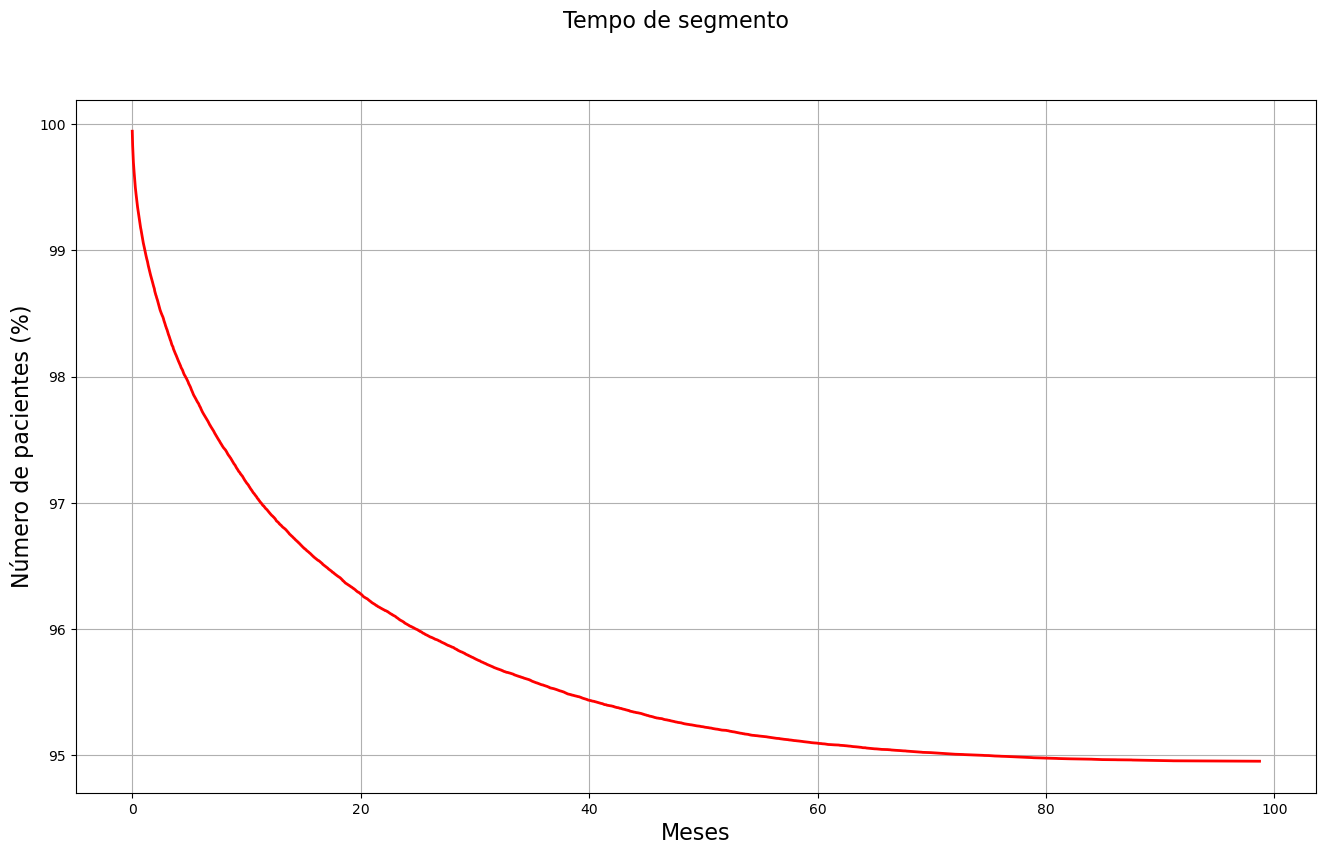

In [106]:
fig = plt.figure(figsize=[16, 9])
fig.suptitle("Tempo de segmento", fontsize=16)

# Plotando 2D

ax = fig.add_subplot(1, 1, 1)

ax.set_ylabel("Número de pacientes (%)", fontsize=16)
ax.set_xlabel("Meses", fontsize=16)

ax.plot(unique_delta / 30, percentage, "r", linewidth=2)

ax.grid()

plt.show()

In [107]:
# salvando base de dados
formated_df.to_csv(
    "base_de_dados_formatada.csv",
    index=False,
)

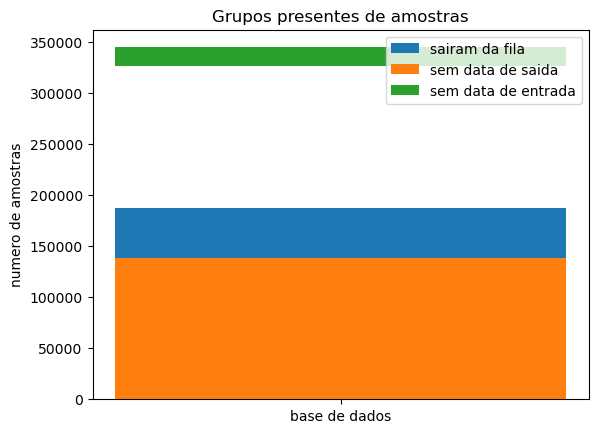

In [2]:
# importing package
import matplotlib.pyplot as plt
import numpy as np

# create data
x = ["base de dados"]
y1 = np.array([187252])
y2 = np.array([325667 - 187253])
y3 = np.array([344410 - 325667])

# plot bars in stack manner
plt.bar(x, y1)
plt.bar(x, y2)
plt.bar(x, y3, bottom=y1 + y2)

plt.ylabel("numero de amostras")
plt.legend(["sairam da fila", "sem data de saida", "sem data de entrada"])
plt.title("Grupos presentes de amostras")
plt.show()

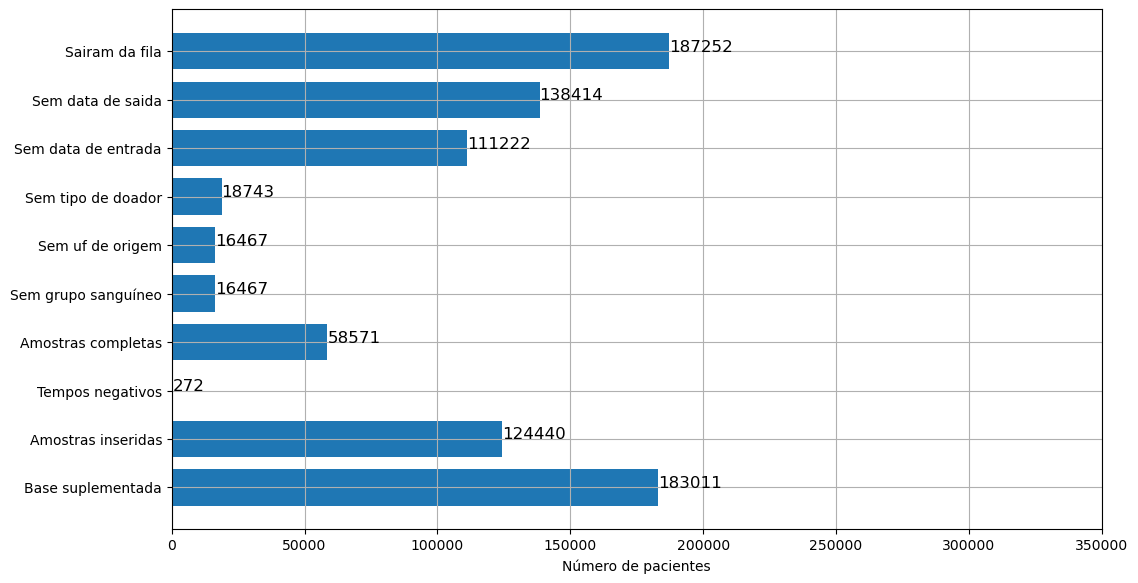

In [1]:
import matplotlib.pyplot as plt
import numpy as np

k = 0.75

fig = plt.figure(figsize=[k*16, k*9])

# Example data
people = (
    "Sairam da fila",
    "Sem data de saida",
    "Sem data de entrada",
    "Sem tipo de doador",
    "Sem uf de origem",
    "Sem grupo sanguíneo",
    "Amostras completas",
    "Tempos negativos",
    "Amostras inseridas",
    "Base suplementada"
)
y_pos = np.arange(len(people))
performance = [
    187252,
    (325667 - 187253),
    (187252 - 76030),
    (344410 - 325667),
    (187252 - 170785),
    (187252 - 170785),
    58571,
    272,
    (183011-58571),
    (183011)
    
]

ax = fig.add_subplot(1, 1, 1)

width = 0.75

ax.barh(y_pos, performance, width, align="center",)

for i, v in enumerate(performance):
    ax.text(v, i, str(v), fontsize=12)

ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Número de pacientes")
ax.set_xlim(0,350000)
ax.grid()

plt.show()

In [15]:
print(187252)
print(325667 - 187253)
print(187252 - 76030)
print(344410 - 325667)
print(187252 - 170785)
print(187252 - 170785)

187252
138414
111222
18743
16467
16467
